In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [4]:
training_set = dataset_train['Open'].values
training_set = training_set.reshape(len(training_set),1)

In [5]:
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [6]:
#applying feature scaling ( normalization ) on open stock price
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [8]:
training_set_scaled[4:8, 0]

array([0.07984225, 0.0643277 , 0.0585423 , 0.06568569])

In [9]:
#creating a data structure with 60 timesteps and 1 output
X_train, y_train = [], []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
#first row corresponds to stockprice at the 60th financial day of our trainset 
#all these values are the previous stock prices before t = 60
X_train[0]

array([0.08581368, 0.09701243, 0.09433366, 0.09156187, 0.07984225,
       0.0643277 , 0.0585423 , 0.06568569, 0.06109085, 0.06639259,
       0.0614257 , 0.07474514, 0.02797827, 0.02379269, 0.02409033,
       0.0159238 , 0.01078949, 0.00967334, 0.01642607, 0.02100231,
       0.02280676, 0.02273235, 0.02810849, 0.03212665, 0.0433812 ,
       0.04475779, 0.04790163, 0.0440695 , 0.04648783, 0.04745517,
       0.04873875, 0.03936305, 0.04137213, 0.04034898, 0.04784582,
       0.04325099, 0.04356723, 0.04286033, 0.04602277, 0.05398467,
       0.05738894, 0.05714711, 0.05569611, 0.04421832, 0.04514845,
       0.04605997, 0.04412531, 0.03675869, 0.04486941, 0.05065481,
       0.05214302, 0.05612397, 0.05818885, 0.06540665, 0.06882953,
       0.07243843, 0.07993526, 0.07846566, 0.08034452, 0.08497656])

In [11]:
#based on the above 60 stock prices, we'll train our future RNN to predict the stock price at time t+1
#stock price at time t+1 is nothing but this below one !! 
y_train[0]

0.08627874097775134

In [12]:
X_train.shape

(1198, 60)

In [13]:
#reshaping the array since keras expect a 3D array as input for RNN 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [14]:
X_train.shape

(1198, 60, 1)

In [15]:
#Building the robust RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout


In [16]:
#initialising the RNN as an instance of the sequential class
regressor = Sequential()

In [17]:
#adding the first LSTM layer and some Dropout regularisation
#dropout regularisation is added to prevent overfitting 
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.1))

In [18]:
#adding the 2nd LSTM layer with some dropout regularisation 
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.1))

In [19]:
#adding the 3rd LSTM layer along with some dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.1))

In [20]:
#adding our 4th LSTM layer and some dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(rate = 0.2))

#why return sequences is not set here ?? 

In [21]:
#adding the output layer 
regressor.add(Dense(units = 1))

In [22]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [23]:
#attaching our RNN a powerful optimizer and a loss function
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [24]:
#fitting our model to the training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Train on 1198 samples
Epoch 1/100
1198/1198 [==============================] - 8s 7ms/sample - loss: 0.0414
Epoch 2/100
1198/1198 [==============================] - 0s 394us/sample - loss: 0.0064
Epoch 3/100
1198/1198 [==============================] - 0s 388us/sample - loss: 0.0050
Epoch 4/100
1198/1198 [==============================] - 0s 395us/sample - loss: 0.0056
Epoch 5/100
1198/1198 [==============================] - 0s 389us/sample - loss: 0.0050
Epoch 6/100
1198/1198 [==============================] - 0s 390us/sample - loss: 0.0044
Epoch 7/100
1198/1198 [==============================] - 0s 390us/sample - loss: 0.0047
Epoch 8/100
1198/1198 [==============================] - 0s 390us/sample - loss: 0.0048
Epoch 9/100
1198/1198 [==============================] - 0s 389us/sample - loss: 0.0041
Epoch 10/100
1198/1198 [==============================] - 0s 387us/sample - loss: 0.0037
Epoch 11/100
1198/1198 [==============================] - 0s 390us/sample - loss: 0.0040
Epoch 12/1

In [25]:
#importing the real Google stock price of 2017
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [26]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


In [27]:
realStockPrice = dataset_test['Open'].values
realStockPrice = realStockPrice.reshape(len(realStockPrice),1)

In [28]:
realStockPrice

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

In [29]:
#getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
dataset_total

0     325.25
1     331.27
2     329.83
3     328.34
4     322.04
       ...  
15    829.62
16    837.81
17    834.71
18    814.66
19    796.86
Name: Open, Length: 1278, dtype: float64

In [30]:
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs

array([779.  , 779.66, 777.71, 786.66, 783.76, 781.22, 781.65, 779.8 ,
       787.85, 798.24, 803.3 , 795.  , 804.9 , 816.68, 806.34, 801.  ,
       808.35, 795.47, 782.89, 778.2 , 767.25, 750.66, 774.5 , 783.4 ,
       779.94, 791.17, 756.54, 755.6 , 746.97, 755.2 , 766.92, 771.37,
       762.61, 772.63, 767.73, 764.26, 760.  , 771.53, 770.07, 757.44,
       744.59, 757.71, 764.73, 761.  , 772.48, 780.  , 785.04, 793.9 ,
       797.4 , 797.34, 800.4 , 790.22, 796.76, 795.84, 792.36, 790.9 ,
       790.68, 793.7 , 783.33, 782.75, 778.81, 788.36, 786.08, 795.26,
       806.4 , 807.86, 805.  , 807.14, 807.48, 807.08, 805.81, 805.12,
       806.91, 807.25, 822.3 , 829.62, 837.81, 834.71, 814.66, 796.86])

In [31]:
inputs = inputs.reshape(-1,1)
inputs

array([[779.  ],
       [779.66],
       [777.71],
       [786.66],
       [783.76],
       [781.22],
       [781.65],
       [779.8 ],
       [787.85],
       [798.24],
       [803.3 ],
       [795.  ],
       [804.9 ],
       [816.68],
       [806.34],
       [801.  ],
       [808.35],
       [795.47],
       [782.89],
       [778.2 ],
       [767.25],
       [750.66],
       [774.5 ],
       [783.4 ],
       [779.94],
       [791.17],
       [756.54],
       [755.6 ],
       [746.97],
       [755.2 ],
       [766.92],
       [771.37],
       [762.61],
       [772.63],
       [767.73],
       [764.26],
       [760.  ],
       [771.53],
       [770.07],
       [757.44],
       [744.59],
       [757.71],
       [764.73],
       [761.  ],
       [772.48],
       [780.  ],
       [785.04],
       [793.9 ],
       [797.4 ],
       [797.34],
       [800.4 ],
       [790.22],
       [796.76],
       [795.84],
       [792.36],
       [790.9 ],
       [790.68],
       [793.7 ],
       [783.33

In [32]:
#scaling these inputs
inputs = sc.transform(inputs)
inputs

array([[0.9299055 ],
       [0.93113327],
       [0.92750577],
       [0.94415507],
       [0.93876032],
       [0.93403527],
       [0.93483518],
       [0.9313937 ],
       [0.94636878],
       [0.96569685],
       [0.97510976],
       [0.95966962],
       [0.97808617],
       [1.        ],
       [0.98076494],
       [0.97083116],
       [0.98450406],
       [0.96054394],
       [0.9371419 ],
       [0.92841729],
       [0.90804747],
       [0.8771858 ],
       [0.92153434],
       [0.93809063],
       [0.93165414],
       [0.95254483],
       [0.88812412],
       [0.88637547],
       [0.87032145],
       [0.88563137],
       [0.90743359],
       [0.91571173],
       [0.89941588],
       [0.91805566],
       [0.9089404 ],
       [0.9024853 ],
       [0.89456061],
       [0.91600938],
       [0.9132934 ],
       [0.88979835],
       [0.86589404],
       [0.89030062],
       [0.90335962],
       [0.89642086],
       [0.91777662],
       [0.93176576],
       [0.94114145],
       [0.957

In [33]:
len(inputs)

80

In [34]:
#creating a data structure with 60 timesteps for test set
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)

In [35]:
#these are the previous 60 stock prices of the first financial day of Jan, 2017
#basically this is the last 3 months data from the train set
X_test[0]

array([0.9299055 , 0.93113327, 0.92750577, 0.94415507, 0.93876032,
       0.93403527, 0.93483518, 0.9313937 , 0.94636878, 0.96569685,
       0.97510976, 0.95966962, 0.97808617, 1.        , 0.98076494,
       0.97083116, 0.98450406, 0.96054394, 0.9371419 , 0.92841729,
       0.90804747, 0.8771858 , 0.92153434, 0.93809063, 0.93165414,
       0.95254483, 0.88812412, 0.88637547, 0.87032145, 0.88563137,
       0.90743359, 0.91571173, 0.89941588, 0.91805566, 0.9089404 ,
       0.9024853 , 0.89456061, 0.91600938, 0.9132934 , 0.88979835,
       0.86589404, 0.89030062, 0.90335962, 0.89642086, 0.91777662,
       0.93176576, 0.94114145, 0.95762334, 0.96413424, 0.96402262,
       0.96971501, 0.95077759, 0.96294367, 0.96123223, 0.95475854,
       0.95204256, 0.95163331, 0.95725128, 0.93796041, 0.93688146])

In [36]:
X_test.shape

(20, 60)

In [37]:
#reshaping into 3D 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_test.shape

(20, 60, 1)

In [38]:
X_test[0][0][0]

0.9299054989210507

In [39]:
#predicting the stock prices of Jan, 2017 and scaling it back
predictedStockPrice = sc.inverse_transform(regressor.predict(X_test))
predictedStockPrice

array([[770.6945 ],
       [767.51166],
       [767.7084 ],
       [769.1085 ],
       [772.53265],
       [778.6009 ],
       [783.8288 ],
       [785.26984],
       [784.6336 ],
       [783.53754],
       [782.7248 ],
       [782.19037],
       [782.00085],
       [782.7971 ],
       [784.15564],
       [789.6215 ],
       [797.4495 ],
       [805.4191 ],
       [809.149  ],
       [803.5509 ]], dtype=float32)

In [40]:
train_plot = sc.inverse_transform(regressor.predict(X_train))

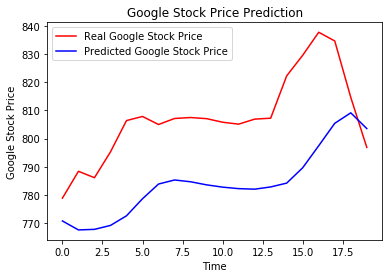

In [41]:
#Visualising the predictions over the real stock prices
plt.plot(realStockPrice, color = 'red', label = 'Real Google Stock Price')
plt.plot(predictedStockPrice, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.ylim((0, 850))
plt.legend()
plt.show()

In [42]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(realStockPrice, predictedStockPrice))

In [43]:
rmse

25.905394844175376

In [44]:
#17.1967
#21.4810

In [45]:
#Understanding the test train split
#Diffent parameter setting 
#Explore Grid search CV
#Explore different models in RNN 
#compare with same parameter setting
#4 W and 1 H